In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [3]:
graph_list = torch.load("graph_lists/graph_list_35nf_1ef.pt", weights_only=False)

In [38]:
graph = graph_list[0]

In [52]:
subset = torch.tensor(list(range(5)))

In [53]:
# Filtramos aristas donde ambos nodos están en el subset
node_mask = torch.zeros(graph.num_nodes, dtype=torch.bool)
node_mask[subset] = True

edge_mask = node_mask[graph.edge_index[0]] & node_mask[graph.edge_index[1]]

# Extraer sólo esas aristas y sus pesos
new_edge_index = graph.edge_index[:, edge_mask]
new_edge_weight = graph.edge_attr[edge_mask]

subgraph = Data(x=graph.x[subset], edge_index=new_edge_index, edge_weight=new_edge_weight)

In [81]:
G = to_networkx(subgraph, edge_attrs=['edge_weight'], to_undirected=False)
pos = nx.spring_layout(G, seed=42)

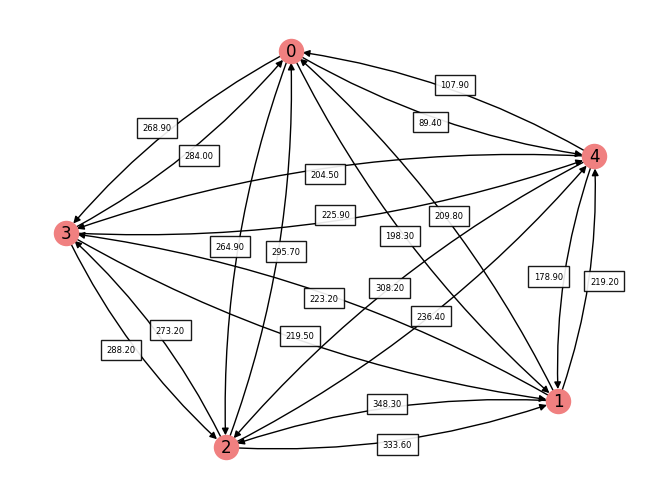

In [82]:
# plt.figure(figsize=(5, 4))
nx.draw(G, pos, with_labels=True, arrows=True, connectionstyle='arc3,rad=0.1', node_color="lightcoral")

# Crea las etiquetas formateadas
edge_labels_raw = nx.get_edge_attributes(G, 'edge_weight')
edge_labels = {}
for k, v in edge_labels_raw.items():
    if isinstance(v, (list, tuple)):
        val = v[0]
    elif isinstance(v, torch.Tensor):
        val = v.item()
    else:
        val = v
    edge_labels[k] = f"{val:.2f}"

# Función para calcular posición desplazada para cada etiqueta
def offset_edge_label_pos(pos, src, dst, offset=0.1):
    x1, y1 = pos[src]
    x2, y2 = pos[dst]
    mx, my = (x1 + x2) / 2, (y1 + y2) / 2  # punto medio
    dx, dy = y2 - y1, x1 - x2               # vector perpendicular
    length = (dx**2 + dy**2)**0.5
    if length == 0:
        return mx, my
    ox, oy = offset * dx / length, offset * dy / length
    return mx + ox, my + oy

# Ahora dibuja etiquetas manualmente con offset para aristas opuestas
for (src, dst), label in edge_labels.items():
    # Usa offset positivo o negativo si la arista inversa existe
    if (dst, src) in G.edges():
        x, y = offset_edge_label_pos(pos, src, dst, offset=0.1)
    else:
        x, y = offset_edge_label_pos(pos, src, dst, offset=0)
    plt.text(x, y, label, fontsize=6, bbox=dict(facecolor='white', alpha=0.9), horizontalalignment='center', verticalalignment='center')

plt.show()